Objective: To develop and evaluate a text classification system capable of categorizing user feedback into four distinct classes: Feature Requests, Problem Discovery, Information Giving, and Information Seeking.

**0. Installing Necessary Libraries**

In [1]:
!pip install pandas

In [2]:
!pip install openpyxl

In [3]:
!pip install transformers==4.57.5

In [4]:
!pip install torch

In [5]:
!pip install -U accelerate

In [6]:
!pip install wordcloud

In [7]:
!pip install matplotlib

In [8]:
!pip install seaborn

**1. Data Exploration:**
The dataset consists of user reviews for a mobile application, labeled by intent. Understanding the distribution of these classes is crucial for identifying potential biases and selecting appropriate evaluation metrics.

1.1 Data Loading

In [9]:
import pandas as pd

# Load dataset
df = pd.read_excel("review.xlsx")
df.head()

,id,review,class
0,39,Make it like better with a giant pig bigger th...,feature request
1,42,These screens are small enough without crowdin...,information giving
2,49,Dear Rovio; If you absolutely must continue tr...,information giving
3,56,App crashes when new power up notice pops up.,problem discovery
4,62,It would be nice to have an update that didn ...,information giving


1.2 Data Exploration: Initial Inspection

class
information giving     603
problem discovery      494
feature request        192
information seeking    101
Name: count, dtype: int64


/tmp/ipykernel_3066/1660518679.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


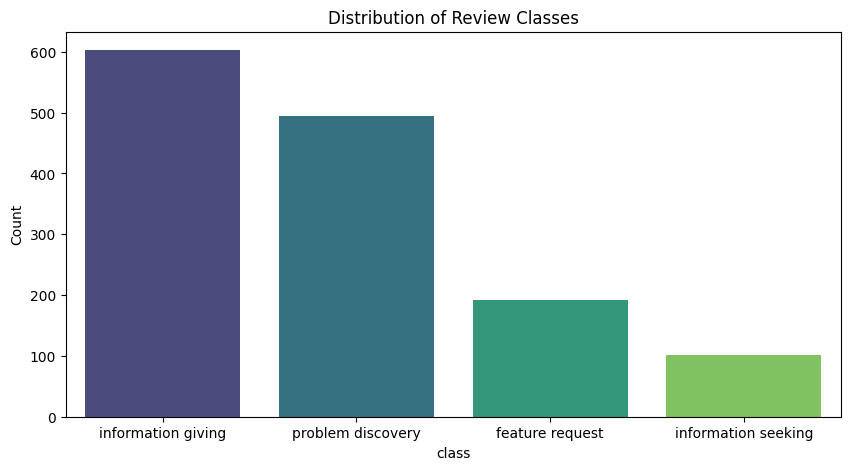

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Display distribution
class_counts = df['class'].value_counts()
print(class_counts)

# Visualization: Class Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Review Classes')
plt.ylabel('Count')
plt.show()

1.3 Data Exploration: Word Clouds

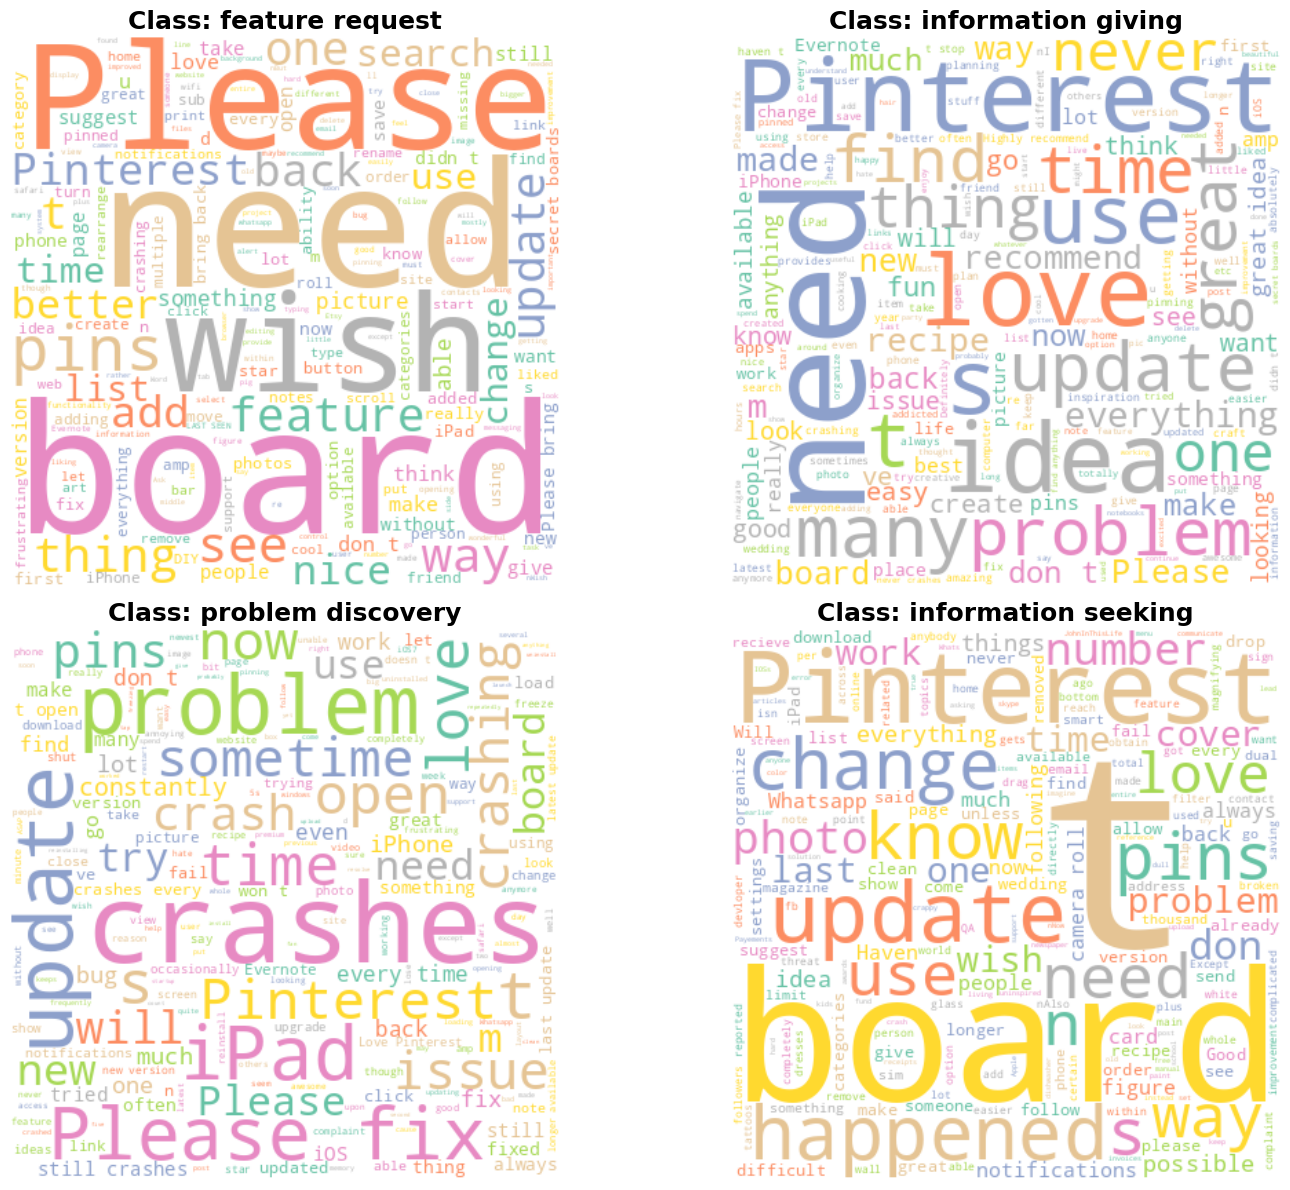

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# 1. Setup Stopwords
stopwords = set(STOPWORDS)
stopwords.update(["and", "it", "to", "the", "is", "of", "app", "this", "my", "pin"])

# 2. Get the list of unique classes
classes = df['class'].unique()

# 3. Create a multi-plot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, cls in enumerate(classes):
    # Filter text by class using the original 'df'
    text_data = " ".join(review for review in df[df['class'] == cls].review)
    
    # Generate Word Cloud
    wordcloud = WordCloud(
        width=400, height=400,
        background_color='white',
        stopwords=stopwords,
        colormap='Set2'
    ).generate(text_data)
    
    # Plot in subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Class: {cls}", fontsize=18, fontweight='bold')
    axes[i].axis("off")

plt.tight_layout()
plt.show()

**2. Preprocessing and Feature Engineering**: Before modeling, the data must be cleaned, converted to numerical format and splitted for training and testing.

2.1. Cleaning Data

In [12]:
#removing extra id column
df_id_removed = df.drop(columns=['id'])
df_id_removed.head()

,review,class
0,Make it like better with a giant pig bigger th...,feature request
1,These screens are small enough without crowdin...,information giving
2,Dear Rovio; If you absolutely must continue tr...,information giving
3,App crashes when new power up notice pops up.,problem discovery
4,It would be nice to have an update that didn ...,information giving


2.2. Encoding target labels

In [13]:
#encoding target labels
#reference https://pbpython.com/categorical-encoding.html
find_replace = {"class":     {"feature request": 0, "problem discovery": 1, "information giving": 2, "information seeking": 3}}
target_encoded_df = df_id_removed.replace(find_replace)
target_encoded_df.head()

/tmp/ipykernel_3066/349531014.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_encoded_df = df_id_removed.replace(find_replace)


,review,class
0,Make it like better with a giant pig bigger th...,0
1,These screens are small enough without crowdin...,2
2,Dear Rovio; If you absolutely must continue tr...,2
3,App crashes when new power up notice pops up.,1
4,It would be nice to have an update that didn ...,2


In [14]:
target_encoded_df['class'].value_counts()

class
2    603
1    494
0    192
3    101
Name: count, dtype: int64

2.3. Splitting Training and Testing Datasets

In [15]:
#train test split

In [16]:
from sklearn.model_selection import train_test_split

X = target_encoded_df['review']
y = target_encoded_df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1112,), (278,), (1112,), (278,))

2.4. Converting text to numerical features using an optimized TF-IDF vectorizer, fitted strictly on the training set to prevent data leakage.

In [18]:
#TF-IDF Feature Extraction
#TF - Term Frequency
#IDF - Inverse Document Frequecy

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(
#     lowercase=True,
#     stop_words='english',
#     max_df=0.9,
#     min_df=5,
#     ngram_range=(1, 2)
# ) 
# Accuracy: 0.6510791366906474

# tfidf = TfidfVectorizer(
#     analyzer="char_wb",
#     ngram_range=(3, 5),
#     min_df=3,
#     sublinear_tf=True
# )Accuracy: 0.6330935251798561

# tfidf = TfidfVectorizer(
#     lowercase=True,
#     stop_words='english',
#     max_df=0.9,
#     min_df=5,
#     ngram_range=(1, 3)
# ) Accuracy: 0.6510791366906474

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_df=0.2,
    min_df=5,
    ngram_range=(1, 3),
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**3. Implementing Traditional Model**

3.1 Implementing Multinomial Naive Bayes Algorithm

In [20]:
#naive bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("Training Completed")

Training Completed


In [22]:
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.6510791366906474
              precision    recall  f1-score   support

           0       0.71      0.26      0.38        38
           1       0.74      0.64      0.68        99
           2       0.60      0.87      0.71       121
           3       1.00      0.15      0.26        20

    accuracy                           0.65       278
   macro avg       0.76      0.48      0.51       278
weighted avg       0.69      0.65      0.62       278

Confusion Matrix:

[[ 10   6  22   0]
 [  1  63  35   0]
 [  2  14 105   0]
 [  1   2  14   3]]


3.2 Implementing Logistic Regression Algorithm

In [23]:
#logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=-1
)

clf.fit(X_train_tfidf, y_train)
print("Training Completed")

Training Completed


/home/kebal/project/review-radar/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [25]:
y_pred = clf.predict(X_test_tfidf)

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 0.5719424460431655

Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.53      0.42        38
           1       0.82      0.62      0.71        99
           2       0.63      0.59      0.61       121
           3       0.21      0.35      0.26        20

    accuracy                           0.57       278
   macro avg       0.50      0.52      0.50       278
weighted avg       0.63      0.57      0.59       278

Confusion Matrix:

[[20  3 13  2]
 [ 9 61 21  8]
 [24 10 71 16]
 [ 5  0  8  7]]


**4. Implementing Bert Model**

In [26]:
#bert

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Dataset wrapper
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = ReviewDataset(train_encodings, y_train.tolist())
test_dataset = ReviewDataset(test_encodings, y_test.tolist())

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Trainer
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     eval_strategy='epoch',
#     save_strategy='epoch',
#     logging_dir='./logs',
#     logging_steps=10,
#     load_best_model_at_end=True
# )
# Epoch	Training Loss	Validation Loss	Accuracy	F1	Precision	Recall
# 1	0.559000	0.566445	0.802158	0.781403	0.798839	0.802158
# 2	0.457400	0.535569	0.798561	0.800712	0.808069	0.798561
# 3	0.198300	0.558971	0.805755	0.804878	0.804605	0.805755

#stopping training early to prevent overfitting

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3066/2830338554.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.627600,0.678854,0.751799,0.736699,0.735099,0.751799
2,0.463400,0.623749,0.758993,0.766132,0.777208,0.758993


TrainOutput(global_step=140, training_loss=0.6903115374701364, metrics={'train_runtime': 46.9086, 'train_samples_per_second': 47.411, 'train_steps_per_second': 2.985, 'total_flos': 138292009544832.0, 'train_loss': 0.6903115374701364, 'epoch': 2.0})

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

pred_output = trainer.predict(test_dataset)

y_pred_bert = np.argmax(pred_output.predictions, axis=1)

print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_bert))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_bert))


BERT Accuracy: 0.7589928057553957

Classification Report:

              precision    recall  f1-score   support

           0       0.43      0.55      0.48        38
           1       0.90      0.81      0.85        99
           2       0.79      0.79      0.79       121
           3       0.79      0.75      0.77        20

    accuracy                           0.76       278
   macro avg       0.73      0.72      0.72       278
weighted avg       0.78      0.76      0.77       278

Confusion Matrix:

[[21  3 11  3]
 [ 6 80 13  0]
 [20  5 95  1]
 [ 2  1  2 15]]
